In [586]:
import sys
sys.path.append('../scripts/')

import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from epsilon_tools import *

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='notebook', palette='colorblind',font_scale=1.5)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [116]:
ds = xr.open_dataset('../data/chi/variable_dof.nc')

In [697]:
def compute_batchelor_spectrum(f_cps , chi, kb):
    w = 0.1
    k_rpm = f_cps* 2 * np.pi/w
    return [k_rpm, batchelor(k_rpm,chi, kb, p)]

def compute_kraichnan_spectrum(f_cps , chi, kb):
    w = 0.1
    k_rpm = f_cps* 2 * np.pi/w
    return [k_rpm, kraichnan(k_rpm,chi, kb, p)]

In [735]:
def logbin_data(f_cps, logbins, chi, kb):

    digit = np.digitize(f_cps, logbins)
    ks=[]
    bs=[]
    count=[]
    for i in range(len(logbins)):
        ks.append( np.nanmean( compute_kraichnan_spectrum( f_cps[digit==i] , chi, kb)[0] ))
        bs.append( np.nanmean( compute_kraichnan_spectrum( f_cps[digit==i], chi, kb)[1] ) )
        count.append(np.sum(digit==i))

    return np.array(ks), np.array(bs), np.array(count)

In [736]:
def cost_function(kb, k_rpm, chi, noise, corrdTdz, dof, function):
    '''
    Cost function for MLE to fit spectra
    '''
    import bottleneck as bn
    from epsilon_tools import batchelor

    def chisquared(x, dof):
        from scipy.special import xlogy, gammaln
        import math
        import numpy as np
        return np.exp( xlogy(dof/2-1, x) - x/2 - gammaln(dof/2.) - (math.log(2)*dof)/2 )

    if function.lower() == 'batchelor':
        theory = batchelor(k_rpm, chi, kb, p)
    elif function.lower() == 'kraichnan':
        theory = kraichnan(k_rpm, chi, kb, p)
    elif function.lower() == 'power':
        theory = kb[0]*k_rpm**(-kb[1])
    else:
        raise ValueError('Function not known!')

    a = dof / (theory + noise)
    b = chisquared(corrdTdz * a, dof)
    
#     c = np.log(a) + np.log(b)
#     - np.nansum( np.log(a) ) - np.nansum( np.log(b[b>0]))

    return -np.nansum( np.log(a) ) - np.nansum( np.log(b[b!=0]))

In [737]:
def noise_sp(f_cps):
    ''' 
    Empirical noise spectrum
    '''
    return 1e-11 * (1 + (f_cps / 15)**3)**2

In [952]:
def trial_eps_estimation(f_cps, kbs, variable_dof):
    p = Parameters()
    chi=1e-8
    w = 0.1

    # logbins = np.logspace(-2,2,20)
    logbins = ds.f_cps.values

        
    estimated_kb = []
    for kb in kbs:
        meank, meanb, count = logbin_data(f_cps, logbins, chi, kb)

        if variable_dof:
            dof = ds.isel(time=0).dof.values
#             dof = 2*count
        else:
            dof = 100
        
        k_rpm = meank
        noise = meank**2*noise_sp(meank*w/(2*np.pi))*w/ (2 * np.pi)
        b_rpm = meanb #+noise

        args = (k_rpm, chi, noise, b_rpm, dof, 'kraichnan')
        options = {'maxiter':100,'xatol':1e-6,'fatol':1e-6}
        m = minimize(cost_function, x0=500, args=args, method='Nelder-Mead', options=options)
        if m.success:
            estimated_kb.append(m.x)
        else:
            print(f'{m.message}')
            estimated_kb.append(np.nan)
    return np.array( estimated_kb ).astype(float)

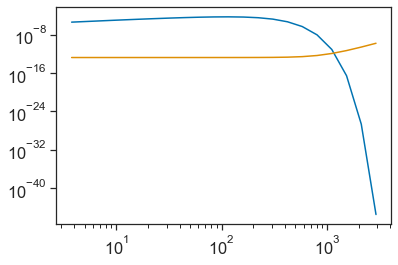

In [953]:
plt.loglog(k_rpm, meanb )
plt.loglog(k_rpm, noise);

In [954]:
kbs = np.linspace(250,500,600)
f_cps = np.linspace(0,60,2000)

variable = trial_eps_estimation(f_cps, kbs, True)
fixed = trial_eps_estimation(f_cps, kbs, False)

In [955]:
def epsilon(kb):
    return kb**4 * p.nu * p.D**2

def eps2kb(eps):
    return (eps/(p.nu * p.D**2))**(1/4)

(0.9, 1.1)

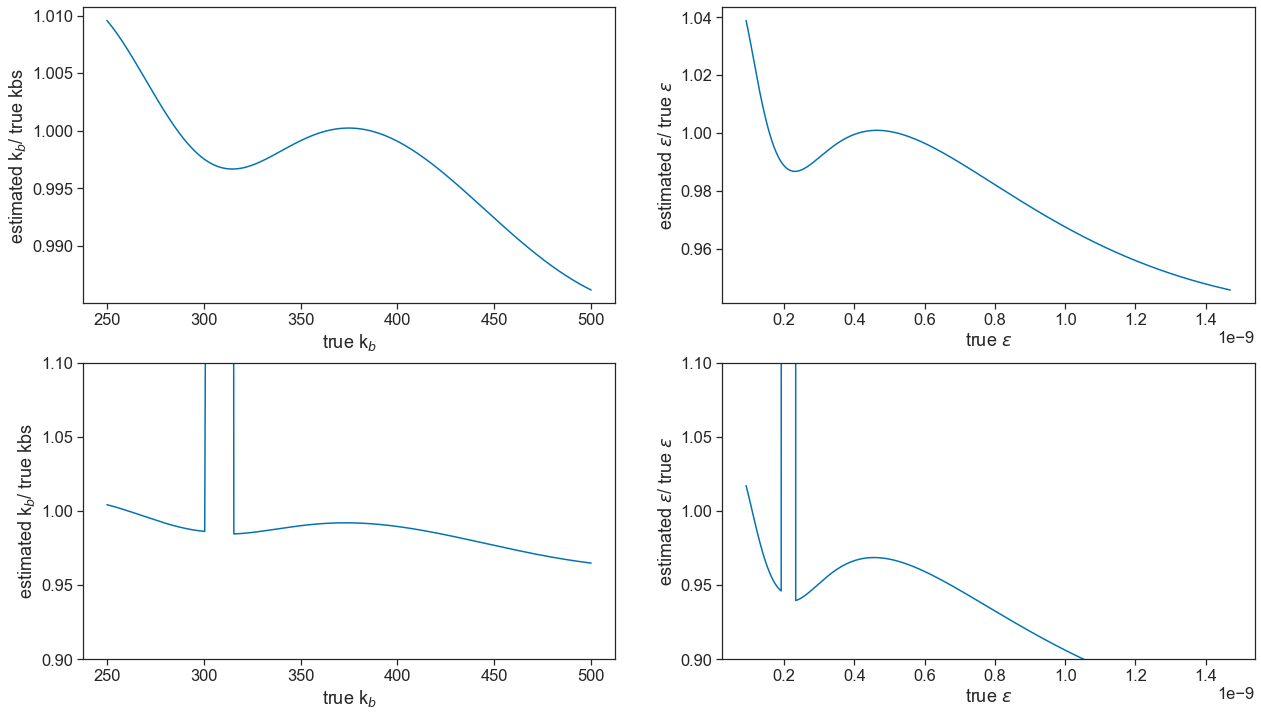

In [956]:
f, ax = plt.subplots(2,2, figsize=(21,12))

ax = ax.flatten()
ax[0].plot(kbs, fixed.flatten()/kbs)
ax[0].set_ylabel(r'estimated k$_b$/ true kbs')
ax[0].set_xlabel(r'true k$_b$');

ax[1].plot( epsilon(kbs), epsilon( fixed.flatten())/epsilon(kbs))
ax[1].set_ylabel(r'estimated $\epsilon$/ true $\epsilon$')
ax[1].set_xlabel(r'true $\epsilon$');

ax[2].plot(kbs, variable.flatten()/kbs)
ax[2].set_ylabel(r'estimated k$_b$/ true kbs')
ax[2].set_xlabel(r'true k$_b$');
ax[2].set_ylim(0.9,1.1)

ax[3].plot( epsilon(kbs), epsilon( variable.flatten())/epsilon(kbs))
ax[3].set_ylabel(r'estimated $\epsilon$/ true $\epsilon$')
ax[3].set_xlabel(r'true $\epsilon$');
ax[3].set_ylim(0.9,1.1)

In [957]:
def perfect_kraichnan():
    

SyntaxError: unexpected EOF while parsing (<ipython-input-957-ced95ed4512e>, line 2)

In [1026]:
f,ax = plt.subplots(1,2, figsize=(15,6), sharey=True, dpi=100)

colors = sns.color_palette(n_colors=4)

k_rpm = np.logspace(-1,3)
fixed_kb = 400
variable_chi = [1e-7,1e-8,1e-9,1e-10]

for i,chi in enumerate( variable_chi ):
    ax[0].plot(k_rpm, kraichnan(k_rpm,chi, fixed_kb, p), label=f'$\chi$ = {chi}', color=colors[i])
    ax[0].plot(k_rpm, batchelor(k_rpm,chi, fixed_kb, p), label=f'_{chi}', lw=1, ls='dotted', color=colors[i])
    
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Fixed k$_b$, variable $\chi$')
ax[0].set_ylabel('Temperature gradient spectrum')
ax[0].set_xlabel('k$_z$')
ax[0].set_ylim(1e-12,1e-2)
ax[0].legend()

variable_kb = [300, 400, 500, 600]
fixed_chi = 1e-9
for i,kb in enumerate(variable_kb):
    eps = kb**4*p.D**2*p.nu
    ax[1].plot(k_rpm, kraichnan(k_rpm,fixed_chi, kb, p), label=f'$k_b$ = {kb} $\rightarrow$ $\epsilon$ = {eps:1.2e}', color=colors[i])
    ax[1].plot(k_rpm, batchelor(k_rpm,fixed_chi, kb, p), label=f'_{kb}', lw=1, ls='dotted', color=colors[i])

ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Fixed $\chi$, variable k$_b$')
ax[1].set_xlabel('k$_z$')
ax[1].legend()

plt.subplots_adjust(wspace=0.1)
plt.savefig('../figures/kraichnan_model.pdf')
plt.show()

ValueError: 
$k_b$ = 300 $ightarrow$ $\epsilon$ = 1.91e-10
            ^
Expected end of text, found '$'  (at char 12), (line:1, col:13)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1a193781e0> (for post_execute):


ValueError: 
$k_b$ = 300 $ightarrow$ $\epsilon$ = 1.91e-10
            ^
Expected end of text, found '$'  (at char 12), (line:1, col:13)

ValueError: 
$k_b$ = 300 $ightarrow$ $\epsilon$ = 1.91e-10
            ^
Expected end of text, found '$'  (at char 12), (line:1, col:13)

<Figure size 1500x600 with 2 Axes>

In [1009]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [1015]:
@interact
def scatter(chi=list(variable_chi),kb=list(variable_kb)):
    plt.plot(k_rpm,batchelor(k_rpm,chi, kb, p))
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-12,1e-2)

interactive(children=(Dropdown(description='chi', options=(1e-07, 1e-08, 1e-09, 1e-10), value=1e-07), Dropdown…